In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib.ticker import ScalarFormatter
from scipy.integrate import cumulative_trapezoid, trapezoid
import math
import os
import time
import random
import pickle as pkl
from cratersfd import *
%matplotlib inline
mpl.rcParams['font.family'] = 'Helvetica'

In [2]:
latitude_factor = np.cos(math.pi * (26 + 11 / 60) / 180)
pixel_factor = 0.626608880720610
cfactor = latitude_factor * pixel_factor
rawd = pd.read_csv(
    '../data/M146959973L.txt', delimiter='\t'
) * cfactor
ds = np.array(sorted(rawd['D_wm'].tolist())) / 1000
w = 4000 * cfactor / 1000
h = 2215 * cfactor / 1000
area = h * w

In [3]:
cum_dmin = 0.09
dmin_estimate = 0.14
N_cum = ds[ds >= cum_dmin].size
N = ds[ds >= dmin_estimate].size
d_random, d_systematic = 1.10, 1.02
random, systematic, additional = 1.6, 1.12, 1.1
combined = lambda_error_lognormal(
    N, random=random, systematic=systematic, 
    additional=additional
)
cf_error = 2.5

X = np.linspace(0.13, np.max(ds), 10000)
P = norm.pdf(X, 0.14, 0.05)
dmin_rv = RandomVariable(X, P, kind='median')

s19X = np.linspace(3, 3.58, 10000)
s19P = norm.pdf(s19X, 3.29, 0.01)
age_rv_snape_et_al_2019 = RandomVariable(
    s19X, s19P, kind='median'
)
s19P = s19P / s19P.max()

age_rv_only_counting = age_pdf(
    ds, area, dmin_estimate, only_counting_error=True
)

age_rv_d = age_pdf(
    ds, area, dmin_estimate, kind='median',
    random=1.0, systematic=1.0, additional=1.0, 
    d_random=d_random, d_systematic=d_systematic
)

age_rv_d_lambda = age_pdf(
    ds, area, dmin_estimate, kind='median',
    random=random, systematic=systematic, 
    additional=additional, d_random=d_random, 
    d_systematic=d_systematic
)

age_rv_d_lambda_cf = age_pdf(
    ds, area, dmin_estimate, kind='median',
    random=random, systematic=systematic, 
    additional=additional, d_random=d_random, 
    d_systematic=d_systematic, cf_error=cf_error
)

age_rv_dmin = age_pdf(
    ds, area, dmin_rv, kind='median',
    random=random, systematic=systematic, 
    additional=additional, d_random=d_random, 
    d_systematic=d_systematic
)

age_rv_full = age_pdf(
    ds, area, dmin_rv, kind='median',
    random=random, systematic=systematic, 
    additional=additional, d_random=d_random, 
    d_systematic=d_systematic, cf_error=cf_error
)

s19X = np.linspace(3, 3.58, 10000)
s19P = norm.pdf(s19X, 3.29, 0.01)
age_rv_snape_et_al_2019 = RandomVariable(
    s19X, s19P, kind='median'
)
s19P = s19P / s19P.max()

sampled_rv = dmin_rv.trim(0.99).downsample(50)
dmins, dmin_weights = sampled_rv.X, sampled_rv.P
N_rvs = [
    N_pmf(ds, area, dmin_i, d_random=1.05)
    for dmin_i in dmins
]
N1_rvs = [
    N1_pdf(
        N_rv_i, area, dmin_i, kind='median',
        random=random, systematic=systematic, 
        additional=additional, 
        d_systematic=d_systematic,
        sfd_rv=sash_pdf(ds, area)
    )
    for dmin_i, N_rv_i in zip(dmins, N_rvs)
]
N1_min = np.min([N1_rv.X.min() for N1_rv in N1_rvs])
N1_max = np.max([N1_rv.X.max() for N1_rv in N1_rvs])
X = np.linspace(N1_min, N1_max, 10000)
N1_rv_Ps = [N1_rv.match_X(X).P for N1_rv in N1_rvs]
N1_rv_matrix = np.array([
    P * w for P, w in zip(N1_rv_Ps, dmin_weights)
])
summed_P = N1_rv_matrix.sum(axis=0)
summed_N1_rv_50 = RandomVariable(
    X, summed_P, kind='median'
)

/Users/sam/Library/Python/3.12/lib/python/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/sam/Library/Python/3.12/lib/python/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/sam/Library/Python/3.12/lib/python/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/sam/Library/Python/3.12/lib/python/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Users/sam/Library/Python/3.12/lib/python/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Users/sam/Libra

Calculation time: 0.0002 seconds
Synthetic modeling time: 2.1461 seconds
6e-05 seconds
Synthetic plotting time: 0.55126 seconds
Cumulative plot time: 0.01724 seconds
Random variable ploting time: 1.77908 seconds
Image loading time: 1.1717 seconds
Plots in equations time: 23.32498 seconds
Saving time: 44.32796 seconds


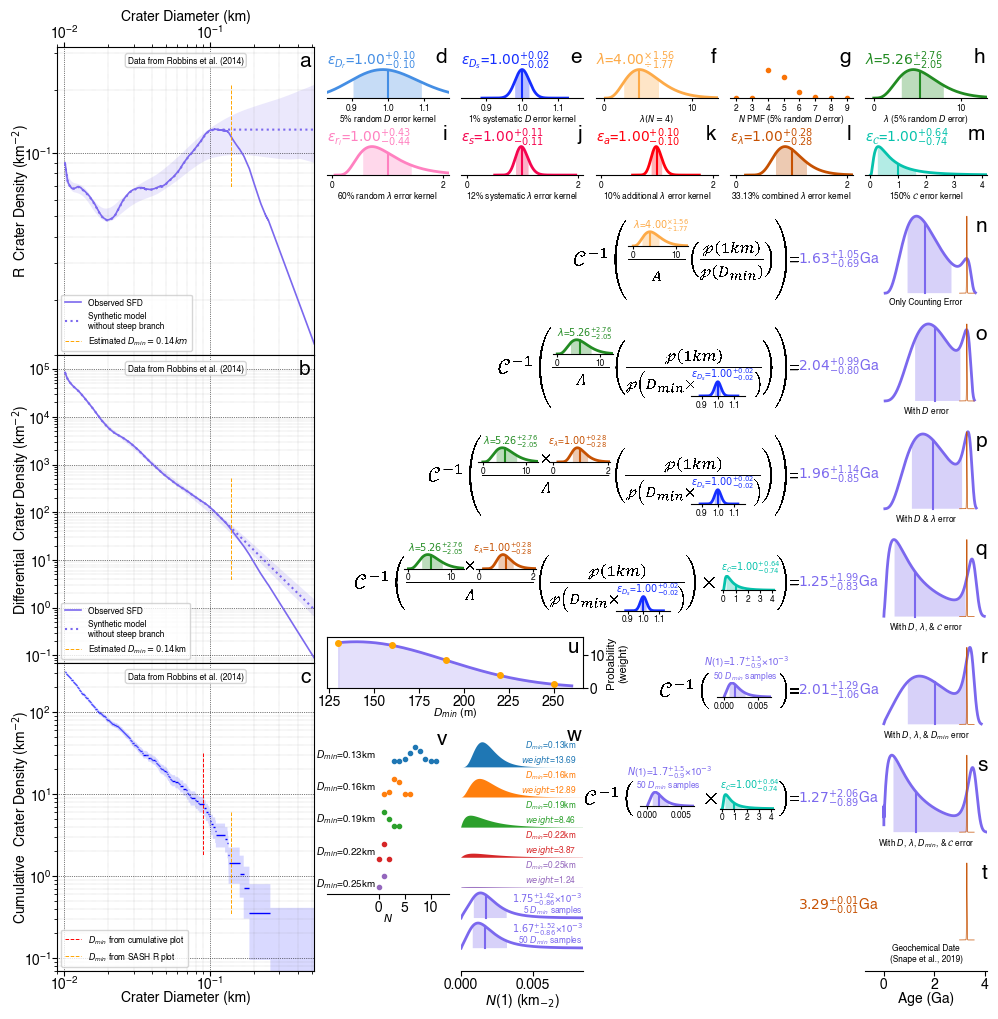

In [4]:
fontsize = 10
rv_fontsize = 6
n_steps = 1000

fig = plt.figure(figsize=(12, 12))
gn = 3
gs = gridspec.GridSpec(12 * gn, 7, figure=fig)

letter_n = ord('a')
def letter(dy=0):
    global letter_n
    plt.text(
        0.985, 0.985 + dy, chr(letter_n), 
        transform=plt.gca().transAxes, 
        ha='right', va='top', size=15
    )
    letter_n += 1

def label_rv(label):
    plt.text(
        0.015, 0.985, label, 
        transform=plt.gca().transAxes, 
        ha='left', va='top', size=8
    )

def format1(xaxis_loc=None, fontsize=fontsize):
    global legend
    ax = plt.gca()
    plt.xlim([0.009, 2 * np.max(ds)])
    ax.tick_params(labelsize=fontsize)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    if xaxis_loc == 'top':
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        ax.xaxis.labelpad = 3
    elif xaxis_loc == 'bottom':
        ax.xaxis.labelpad = -2
    else:
        ax.tick_params(labelbottom=False)
    ax.tick_params(axis='x', which='major', pad=0)
    ax.tick_params(axis='y', which='major', pad=1)
    ax.yaxis.labelpad = 2
    frame = legend.get_frame()
    plt.text(
        0.5, 0.97, 'Data from Robbins et al. (2014)',
        transform=plt.gca().transAxes,
        ha='center', va='top', fontsize=6, bbox={
            'boxstyle' : 'round',
            'facecolor' : frame.get_facecolor(),
            'edgecolor' : frame.get_edgecolor(),
            'linewidth' : frame.get_linewidth(),
            'alpha' : frame.get_alpha(),
        }
    )
    letter()

def format2(xlabel):
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.xlabel(xlabel, size=rv_fontsize)
    ax.xaxis.labelpad = 0
    plt.setp(ax.get_xticklabels(), fontsize=6)
    ax.tick_params(
        axis='both', which='major', pad=2, length=2
    )
    plt.ylim([0, 1.8])
    erase_box(ax)
    letter()
    plt.rcParams['mathtext.fontset'] = 'dejavusans'

def format3():
    plt.rcParams['mathtext.fontset'] = 'stix'
    ax.xaxis.labelpad = 0
    plt.setp(ax.get_xticklabels(), fontsize=6)
    ax.tick_params(
        axis='both', which='major', pad=1, length=2
    )
    erase_box(ax)
    plt.ylim([0, 1.1])
    plt.rcParams['mathtext.fontset'] = 'dejavusans'

ax = plt.subplot(gs[: 4 * gn, :2])
X, R = plot_sash_R(ds, area, fontsize=fontsize)
dmin_estimate_R = np.interp(dmin_estimate, X, R)
dmin_estimate_dif = dmin_estimate_R / dmin_estimate**3
saturated_R_pf = get_saturated_pf(X, R, plot_type='R')
saturated_pf = R2differential_pf(saturated_R_pf)
base = 'saved/age_example_synth.' + str(n_steps)
X_saved = os.path.exists(base + '.X.csv')
Ys_saved = os.path.exists(base + '.Ys.csv')
load_saved = X_saved and Ys_saved
time0()
if load_saved:
    X = np.loadtxt(base + '.X.csv', delimiter=',')
    Ys = np.loadtxt(base + '.Ys.csv', delimiter=',')
    plot_sash_synth(
        ds, area, plot_type='R', n_steps=n_steps,
        differential_pf=saturated_pf, fontsize=fontsize, 
        X=X, synth_mean_Ys=Ys
    )
else:
    X, Ys = plot_sash_synth(
        ds, area, plot_type='R', n_steps=n_steps,
        differential_pf=saturated_pf, fontsize=fontsize
    )
    np.savetxt(base + '.X.csv', X, delimiter=',')
    np.savetxt(base + '.Ys.csv', Ys, delimiter=',')
runtime('Synthetic modeling time')
ylim = [1.1E-2, 3.2E-1]
plt.ylim(ylim)
yf = (ylim[1] / ylim[0]) ** (1 / 6)
plt.plot(
    [dmin_estimate, dmin_estimate],
    dmin_estimate_R * np.array([yf, 1 / yf]), 
    '--', lw=0.7, color='orange'
)
lines = plt.gca().get_lines()
legend = plt.legend(
    lines, [
        'Observed SFD', 
        'Synthetic model\nwithout steep branch',
        rf'Estimated $D_{{min}} = {dmin_estimate}km$'
    ], fontsize=6, loc='lower left'
)
format1(xaxis_loc='top')

ax = plt.subplot(gs[4 * gn : 8 * gn, :2])
ylim = [7E-2, 2E5]
_, Y = plot_sash(ds, area, fontsize=fontsize)
plot_sash_synth(
    ds, area, n_steps=n_steps,
    differential_pf=saturated_pf, fontsize=fontsize, 
    X=X, synth_mean_Ys=Ys
)
yf = (ylim[1] / ylim[0]) ** (1 / 6)
plt.plot(
    [dmin_estimate, dmin_estimate],
    dmin_estimate_dif * np.array([yf, 1 / yf]), 
    '--', lw=0.7, color='orange'
)
lines = plt.gca().get_lines()
plt.legend(
    lines, [
        'Observed SFD', 
        'Synthetic model\nwithout steep branch',
        rf'Estimated $D_{{min}} = {dmin_estimate}$km'
    ], fontsize=6, loc='lower left'
)
format1()
plt.ylim(ylim)
runtime('Synthetic plotting time')

ax = plt.subplot(gs[8 * gn : 12 * gn, :2])
plot_cumulative(ds, area, color='blue', fontsize=fontsize)
ylim = [7E-2, 4E2]
plt.ylim(ylim)
yf = (ylim[1] / ylim[0]) ** (1 / 6)
plt.plot(
    [cum_dmin, cum_dmin],
    N_cum / area * np.array([yf, 1 / yf]),
    '--', lw=0.7, color='red',
    label=rf'$D_{{min}}$ from cumulative plot'
)
plt.plot(
    [dmin_estimate, dmin_estimate], 
    N / area * np.array([yf, 1 / yf]), 
    '--', lw=0.7, color='orange',
    label=rf'$D_{{min}}$ from SASH R plot'
)
plt.legend(fontsize=6)
format1(xaxis_loc='bottom')
runtime('Cumulative plot time')

ax = plt.subplot(gs[: gn - 1, 2])
factor_pdf(d_random).plot(
    xlim=[0.83, 1.17], color=cs[0], label=True,
    force_label_side='left', label_x=0.83, label_y=0.95,
    before_label=rf'$\epsilon_{{D_r}}$=', rounding_n=1
)
format2(rf'5% random $D$ error kernel')

ax = plt.subplot(gs[: gn - 1, 3])
factor_pdf(d_systematic).plot(
    xlim=[0.83, 1.17], color=cs[1], label=True,
    force_label_side='left', label_x=0.83, label_y=0.95,
    before_label=rf'$\epsilon_{{D_s}}$=', rounding_n=1
)
format2(rf'1% systematic $D$ error kernel')

ax = plt.subplot(gs[: gn - 1, 4])
lambda_rv = lambda_pdf(N)
lambda_rv.plot(
    xlim=[-1, 13], color=cs[3], label=True,
    force_label_side='left', label_x=-1, label_y=0.95,
    before_label=rf'$\lambda$='
)
format2(rf'$\lambda(N={N})$')

ax = plt.subplot(gs[: gn - 1, 5])
N_rv = N_pmf(ds, area, dmin_estimate, d_random=1.05)
N_rv.plot(color=cs[4])
plt.xticks(N_rv.X)
format2(rf'$N$ PMF (5% random $D$ error)')

ax = plt.subplot(gs[: gn - 1, 6])
lambda_rv_rv = lambda_pdf(N_rv)
lambda_rv_rv.plot(
    xlim=[-1, 13], color='forestgreen', label=True,
    force_label_side='left', label_x=-1, label_y=0.95,
    before_label=rf'$\lambda$='
)
format2(rf'$\lambda$ (5% random $D$ error)')

for i, factor, name, color, before_label in zip(
    range(2, 6), [random, systematic, additional, combined],
    ['random', 'systematic', 'additional', 'combined'],
    [cs[6], cs[7], cs[8], cs[5]],
    [
        rf'$\epsilon_{{r_i}}$=', rf'$\epsilon_s$=',
        rf'$\epsilon_a$=', rf'$\epsilon_{{\lambda}}$='
    ]
):
    ax = plt.subplot(gs[gn : gn + 2, i])
    factor_pdf(factor).plot(
        xlim=[-0.1, 2.1], color=color, label=True,
        force_label_side='left', label_x=-0.1, label_y=0.95,
        before_label=before_label, rounding_n=1
    )
    percent = round(100 * (factor - 1), 2)
    if name != 'combined':
        percent = int(percent)
    format2(
        str(percent) + '% ' + name + rf' $\lambda$ error kernel'
    )

ax = plt.subplot(gs[gn : gn + 2, 6])
factor_pdf(cf_error).plot(
    xlim=[-0.2, 4.2], color=cs[9], label=True,
    force_label_side='left', label_x=-0.2, label_y=0.95,
    before_label=rf'$\epsilon_{{\mathcal{{C}}}}$=',
    rounding_n=1
)
plt.xticks(range(5))
format2(rf'150% $\mathcal{{C}}$ error kernel')

ax = plt.subplot(gs[gn * 2 :, 6])
rvs = [
    age_rv_only_counting, age_rv_d, age_rv_d_lambda,
    age_rv_d_lambda_cf, age_rv_dmin, age_rv_full
]
labels = [
    'Only Counting Error', rf'With $D$ error', 
    rf'With $D$ & $\lambda$ error',
    rf'With $D$, $\lambda$, & $\mathcal{{C}}$ error',
    rf'With $D$, $\lambda$, & $D_{{min}}$ error',
    rf'With $D$, $\lambda$, $D_{{min}}$, & $\mathcal{{C}}$ error'
]
xlim = [-0.75, 4.1]
upshift = 0
for rv, label in zip(rvs, labels):
    rv.plot(
        label=True, upshift=upshift, xlim=xlim,
        label_x=-3.4, label_y=upshift + 0.3,
        force_label_side='left', unit='Ga'
    )
    plt.text(
        np.mean(xlim), upshift - 0.05, label, ha='center', 
        va='top', size=6
    )
    plt.plot(
        s19X, upshift + s19P, lw=0.5, color=cs[5]
    )
    plt.text(
        4.1, upshift + 1.0, chr(letter_n), 
        ha='right', va='top', size=15
    )
    upshift -= 1.4
    letter_n += 1
age_rv_snape_et_al_2019.plot(
    label=True, upshift=upshift, xlim=xlim, color=cs[5], 
    lw=0.5, plot_error_bars=False, 
    label_x=-3.4, label_y=upshift + 0.3,
    force_label_side='left', unit='Ga'
)
plt.text(
    np.mean(xlim), upshift - 0.05, 
    'Geochemical Date\n(Snape et al., 2019)', 
    ha='center', va='top', size=6
)
plt.text(
    4.1, upshift + 1.0, chr(letter_n), 
    ha='right', va='top', size=15
)
letter_n += 1
plt.xlabel('Age (Ga)')
plt.xticks([0, 2, 4])
plt.ylim([upshift - 0.4, 1.2])
erase_box(ax)
ax.xaxis.labelpad = 0
ax.tick_params(
    axis='x', which='major', pad=1, labelsize=fontsize
)
runtime('Random variable ploting time')

for i in range(1, 7):
    y = 0.618 - (i - 1) * 0.09
    if i == 4:
        y += 0.001
    elif i == 5:
        y += 0.0015
    elif i == 6:
        y += 0.002
    axi = fig.add_axes([0.35, y, 0.393, 0.17])
    img = mpimg.imread(
        'eq_imgs/eq_with_blanks_' + str(i) + '.jpg'
    )
    plt.imshow(img, interpolation='none')
    plt.axis('off')
runtime('Image loading time')
    
x, y = -0.06, 0.005
ax = fig.add_axes([0.661 + x, 0.709 + y, 0.05, 0.013])
lambda_rv.plot(
    xlim=[-1, 13], color=cs[3], label=True,
    label_text_size=7, label_x=0.0, label_y=0.9,
    before_label=rf'$\lambda$=', 
    force_label_side='left'
)
format3()

for dx, dy in zip([0, -0.062, -0.062 * 2], [0, -0.09, -0.179]):
    ax = fig.add_axes([
        0.598 + x + dx, 0.619 + y + dy, 0.05, 0.013
    ])
    lambda_rv_rv.plot(
        xlim=[-1, 13], color='forestgreen', label=True,
        label_text_size=7, label_x=0.0, label_y=0.9,
        before_label=rf'$\lambda$=', 
        force_label_side='left'
    )
    format3()

for dx, dy in zip([0, 0, -0.062], [0, -0.09, -0.179]):
    ax = fig.add_axes([
        0.713 + x + dx, 0.584 + y + dy, 0.045, 0.013
    ])
    ax.set_facecolor('none') 
    factor_pdf(d_systematic).plot(
        xlim=[0.83, 1.17], color=cs[1], label=True,
        force_label_side='left', label_x=0.83,
        label_y=0.95, label_text_size=7,
        before_label=rf'$\epsilon_{{D_s}}$=',
        rounding_n=1
    )
    format3()

for dx, dy in zip([0, -0.062], [-0.09, -0.179]):
    ax = fig.add_axes([
            0.596 + x + dx, 0.619 + y + dy, 0.05, 0.013
        ])
    factor_pdf(combined).plot(
        xlim=[-0.1, 2.1], color=cs[5], label=True,
        label_text_size=7, label_x=-0.2, label_y=0.9,
        before_label=rf'$\epsilon_{{\lambda}}$=',
        force_label_side='left', rounding_n=1
    )
    format3()

for dx, dy in zip([0, -0.001], [0, -0.182]):
    ax = fig.add_axes([
            0.738 + x + dx, 0.422 + y + dy, 0.045, 0.013
        ])
    factor_pdf(cf_error).plot(
        xlim=[-0.2, 4.2], color=cs[9], label=True,
        force_label_side='left', label_x=-0.2, label_y=1.05,
        before_label=rf'$\epsilon_{{\mathcal{{C}}}}$=',
        label_text_size=7, rounding_n=1
    )
    plt.xticks(range(5))
    format3()

runtime('Plots in equations time')

ax = plt.subplot(gs[23:25, 2:4])
dmin_rv = dmin_rv.normalize()
plt.fill_between(
    1000 * dmin_rv.X, 0 * np.ones(dmin_rv.P.size), 
    dmin_rv.P, color='mediumslateblue', alpha=0.2
)
plt.plot(
    1000 * dmin_rv.X, dmin_rv.P,
    color='mediumslateblue', lw=2
)
plt.ylim([0, dmin_rv.P.max() * 1.1])
sampled_rv = dmin_rv.trim(0.99).downsample(5)
dmins, dmin_weights = sampled_rv.X, sampled_rv.P
plt.plot(
    1000 * dmins, dmin_weights, '.', 
    color='orange', ms=8
)
ax.xaxis.labelpad = -2
ax.yaxis.tick_right()
ax.yaxis.labelpad = 1
ax.yaxis.set_label_position('right')
ax.tick_params(
    axis='both', which='major', pad=1, labelsize=fontsize
)
plt.xlabel(rf'$D_{{min}}$ (m)', fontsize=8)
plt.ylabel('Probability\n(weight)', fontsize=8)
letter()

ax = plt.subplot(gs[27:33, 2])
upshift = 0
N_rvs = [
    N_pmf(ds, area, dmin_i, d_random=1.05)
    for dmin_i in dmins
]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for dmin_i, N_rv_i, color in zip(dmins, N_rvs, colors):
    N_rv_i.plot(
        upshift=upshift, xlim=[-10, 13.5], color=color
    )
    plt.text(
        -12, 0.5 + upshift,
        rf'$D_{{min}}$=' + str(round(dmin_i, 2)) + 'km',
        ha='left', va='center', size=7
    )
    upshift -= 2.2
plt.xlabel(rf'$N$', fontsize=8)
plt.xticks([0, 5, 10])
ax.xaxis.labelpad = -2
ax.tick_params(
    axis='x', which='major', pad=1, labelsize=fontsize
)
letter(dy=0.08)

ax = plt.subplot(gs[27:, 3])
sfd_rv = sash_pdf(ds, area)
N1_rvs = [
    N1_pdf(
        N_rv_i, area, dmin_i, kind='median',
        random=random, systematic=systematic, 
        additional=additional, 
        d_systematic=d_systematic, sfd_rv=sfd_rv
    )
    for dmin_i, N_rv_i in zip(dmins, N_rvs)
]
N1_min = np.min([N1_rv.X.min() for N1_rv in N1_rvs])
N1_max = np.max([N1_rv.X.max() for N1_rv in N1_rvs])
X = np.linspace(N1_min, N1_max, 10000)
N1_rv_Ps = [N1_rv.match_X(X).P for N1_rv in N1_rvs]
upshift = 0
weighted_Ps = [
    P * w for P, w in zip(N1_rv_Ps, dmin_weights)
]
P_max = np.max([P.max() for P in weighted_Ps])
for P, dmin_i, w, color in zip(
    weighted_Ps, dmins, dmin_weights, colors
):
    plt.fill_between(
        X, upshift * np.ones(X.size), 
        upshift + P / P_max
    )
    plt.text(
        0.008, upshift + 0.05, 
        (
            rf'$D_{{min}}$=' + str(round(dmin_i, 2)) + 'km\n'
            rf'$weight$=' + str(round(w, 2))
        ), ha='right', va='bottom', size=6, color=color
    )
    upshift -= 1.2
plt.xlim([0, 0.0085])
N1_rv_matrix = np.array([
    P * w for P, w in zip(N1_rv_Ps, dmin_weights)
])
summed_P = N1_rv_matrix.sum(axis=0)
summed_N1_rv = RandomVariable(
    X, summed_P, kind='median'
)
summed_N1_rv.plot(
    upshift=upshift, label=True, label_text_size=7,
    pdf_label=rf'5 $D_{{min}}$ samples', 
    pdf_gap_shift=0.15
)
upshift -= 1.2
summed_N1_rv_50.plot(
    upshift=upshift, label=True, label_text_size=7,
    pdf_label=rf'50 $D_{{min}}$ samples', 
    pdf_gap_shift=0.15
)
erase_box(ax)
plt.xlabel(rf'$N$(1) (km$_{{-2}}$)')
plt.ylim([upshift - 0.9, 1.1])
ax.xaxis.labelpad = 0
ax.tick_params(
    axis='x', which='major', pad=1, labelsize=fontsize
)
letter(dy=0.075)

for dx, dy in zip([0.065, 0.001], [-0.089, -0.18]):
    ax = fig.add_axes([
            0.67 + x + dx, 0.422 + dy + y, 0.045, 0.013
        ])
    summed_N1_rv_50.plot(
        xlim=[-1E-3, 7E-3], color='mediumslateblue', label=True,
        force_label_side='left', label_x=-3.0E-3, label_y=1.05,
        before_label=rf'$N$(1)=',
        label_text_size=7, rounding_n=1,
        pdf_label=rf'    50 $D_{{min}}$ samples', 
        pdf_gap_shift=0.9
    )
    format3()

plt.subplots_adjust(hspace=0, wspace=0.1)

f = 'figs/age_problem_example_' + str(n_steps) + '.pdf'
plt.gcf().savefig(f, bbox_inches='tight')

runtime('Saving time')